In [1]:
%matplotlib  inline
import pandas as pd
import numpy as np
from snap import *


def  getGraph(nodes,edges):
    G = TUNGraph.New()
    ## 添加节点
    for node in nodes:
        G.AddNode(node) 
    ## 添加边
    for A,B in edges:
        G.AddEdge(A,B)
    return G


### 入度出度计算
def getInOutDegrees(UGraph=None):
    nodes_stats=[]
    for NI in UGraph.Nodes():
        temp=[NI.GetId(), NI.GetOutDeg(), NI.GetInDeg()]
        nodes_stats.append(temp)
    call_net_nodes=pd.DataFrame(data=nodes_stats,columns=['id','OutDeg','InDeg']).set_index('id')
    return call_net_nodes


##Uses the Clauset-Newman-Moore community detection method for large networks. 
# At every step of the algorithm two communities that contribute maximum positive value 
# to global modularity are merged. Fills CmtyV with all the communities detected and 
# returns the modularity of the network.
def getCNMCommDetect(UGraph=None):
    CmtyV = TCnComV()
    modularity = CommunityCNM(UGraph, CmtyV)
    comm=pd.DataFrame([list(line) for line in list(CmtyV)])
    return comm,modularity

## Uses the Girvan-Newman community detection algorithm based on betweenness centrality on Graph.
def getGNCommDetect(UGraph=None):
    CmtyV = TCnComV()
    modularity = CommunityGirvanNewman(UGraph, CmtyV)
    comm=pd.DataFrame([list(line) for line in list(CmtyV)])
    return comm,modularity

## 得到由图中节点组成的子图
def getSubGraph(Graph,nodes):
    NIdV = snap.TIntV()
    for i in nodes:
        NIdV.Add(i)
    SubGraph = snap.GetSubGraph(Graph, NIdV)
    return SubGraph

def GetStats():
    diam = GetBfsFullDiam(Graph, 100, False)  ## 网络直径
    GraphClustCoeff= GetClustCf (Graph, -1)     ## 聚集系数
    NumTriads=GetTriads(Graph, 50)   ## 三元闭包的个数

# GetEdgesInOut(Graph, Nodes)  ## 社区内部边，社区外部的边，Graph可以是有向图或者无向图。Nodes是图中的节点Id
# snap.GetModularity(Graph, Nodes, 1000)  ## 又Nodes组成的社区的模块度，Gedges是可选参数，如果Gedes和实际不一样则得到的错误的模块度
# # convert undirected graph to directed
# GOut = snap.ConvertGraph(snap.PNGraph, GIn)  ## 实现无向图向有向图的转换，图类别的转换

def apply_packed_function_for_map((dumped_function, item, args, kwargs),):
    """
    Unpack dumped function as target function and call it with arguments.

    :param (dumped_function, item, args, kwargs):
        a tuple of dumped function and its arguments
    :return:
        result of target function
    """
    target_function = dill.loads(dumped_function)
    res = target_function(item, *args, **kwargs)
    return res


def pack_function_for_map(target_function, items, *args, **kwargs):
    """
    Pack function and arguments to object that can be sent from one
    multiprocessing.Process to another. The main problem is:
        «multiprocessing.Pool.map*» or «apply*»
        cannot use class methods or closures.
    It solves this problem with «dill».
    It works with target function as argument, dumps it («with dill»)
    and returns dumped function with arguments of target function.
    For more performance we dump only target function itself
    and don't dump its arguments.
    How to use (pseudo-code):

        ~>>> import multiprocessing
        ~>>> images = [...]
        ~>>> pool = multiprocessing.Pool(100500)
        ~>>> features = pool.map(
        ~...     *pack_function_for_map(
        ~...         super(Extractor, self).extract_features,
        ~...         images,
        ~...         type='png'
        ~...         **options,
        ~...     )
        ~... )
        ~>>>

    :param target_function:
        function, that you want to execute like  target_function(item, *args, **kwargs).
    :param items:
        list of items for map
    :param args:
        positional arguments for target_function(item, *args, **kwargs)
    :param kwargs:
        named arguments for target_function(item, *args, **kwargs)
    :return: tuple(function_wrapper, dumped_items)
        It returs a tuple with
            * function wrapper, that unpack and call target function;
            * list of packed target function and its' arguments.
    """
    dumped_function = dill.dumps(target_function)
    dumped_items = [(dumped_function, item, args, kwargs) for item in items]
    return apply_packed_function_for_map, dumped_items

def getNodeEdge(filename):
    df=pd.read_csv(filename,index_col=0)
    df.drop_duplicates(['cust_a','cust_b'],inplace=True)
    cond=(df.cust_a!=df.cust_b)
    df=df[cond]
    nodes=np.union1d(df.cust_a.unique(),df.cust_b.unique())
    edges=df.values
    return nodes,edges

def getGraph(filename,U=True):
    nodes,edges=getNodeEdge(filename)
    if U:
        G=TUNGraph.New()
    else:
        G=TNGraph.New()
    for node in nodes:
        G.AddNode(node) 
    ## 添加边
    for A,B in edges:
        G.AddEdge(A,B)
    return G

def getNodeStats(UGraph):
    stats_df=getInOutDegrees(UGraph)
    Nodes = TIntFltH()
    Edges = TIntPrFltH()
    GetBetweennessCentr(UGraph, Nodes, Edges, 1.0)
    stats_df['BetweennessCentr']=[Nodes[node] for node in Nodes]
#     stats_df['DegreeCentr']=[GetDegreeCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['ClosenessCentr']=[GetClosenessCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['FarnessCentr']=[GetFarnessCentr(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['NodeEcc']=[GetNodeEcc(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['NodeClustCf']=[GetNodeClustCf(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    stats_df['NodeTriads']=[GetNodeTriads(UGraph, NI.GetId()) for NI in UGraph.Nodes()]
    return stats_df

In [112]:
# app_conatcts=getGraph('../chapter1data/app_contacts.csv',U=False)
# sms=getGraph('../chapter1data/sms_net.csv',U=False)
# call_records=getGraph('../chapter1data/call_record_net.csv',U=False)
sms_MxWcc=GetMxWcc_PNGraph(sms)    
app_conatcts_MxWcc=GetMxScc_PNGraph(app_conatcts)
call_record=GetMxWcc_PNGraph(call_records)

In [69]:
GetMxWccSz_PNGraph(sms)

0.6630393789873975

In [113]:
GetMxWccSz_PNGraph(call_records)   ##最大连通分量占得比例

0.9623965313362239

In [114]:
GetMxWccSz_PNGraph(app_conatcts)

0.9750595189229128

In [107]:
call_records.GetEdges()

11391669

11342955

In [131]:
def UserDiscover(UG):
    degreesNode=getInOutDegrees(UG)
#     delnodes=degreesNode[(degreesNode.OutDeg<2)|(degreesNode.InDeg<2)].index.values
    delnodes=degreesNode[degreesNode.sum(axis=1)<2].index.values

    V = TIntV()
    for i in delnodes:
        V.Add(i)
    DelNodes(UG, V)
    UG=GetMxScc_PNGraph(UG)
    return  UG

def DescGraph(h):
    flag=True
    while flag:
        h=UserDiscover(h)
        h=GetMxScc_PNGraph(h)
        num=h.GetNodes()
        print num
        if num<200000:
            flag=False
    return  h
    
    

In [132]:
# MPCs=DescGraph(app_conatcts)
CDRs=UserDiscover(call_record)  ##6
# SMSs=GetMxWcc_PNGraph(sms)
# SMSs=DescGraph(sms)

In [117]:
dd=getInOutDegrees(call_record)

In [135]:
CDRs.

358717

In [137]:
SavePajek(CDRs,'CDRs.net')

In [67]:
SMSs=GetMxWcc_PNGraph(sms)


In [54]:
sms.GetEdges()

32666

In [81]:
# smsNode_df=getNodeStats(sms_MxWcc)
%time MPCNode_df=getNodeStats(MPCs)

CPU times: user 15min 27s, sys: 169 ms, total: 15min 28s
Wall time: 15min 27s


In [84]:
%time CDRNode_df=getNodeStats(CDRs)

CPU times: user 13min 55s, sys: 263 ms, total: 13min 55s
Wall time: 13min 55s


In [107]:
for i in range(10):
GetBfsFullDiam(sms_MxWcc, 100, False)

5

In [108]:
CDRNode_df.to_csv('result/CDRNode_df.csv')

In [85]:
CDRNode_df.describe()

,OutDeg,InDeg,BetweennessCentr,ClosenessCentr,FarnessCentr,NodeEcc,NodeClustCf,NodeTriads
count,9973.000000,9973.000000,9.973000e+03,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,11.162038,11.162038,2.553706e+04,0.166534,6.121754,14.575053,0.339686,31.066379
std,6.673824,6.695202,6.627614e+04,0.020970,0.959503,1.174380,0.208130,43.348919
min,1.000000,1.000000,0.000000e+00,0.069248,4.357300,11.000000,0.000000,0.000000
25%,7.000000,7.000000,1.598955e+03,0.156805,5.550441,14.000000,0.185606,8.000000
50%,9.000000,9.000000,6.462905e+03,0.170395,5.868732,15.000000,0.303030,18.000000
75%,13.000000,13.000000,2.257678e+04,0.180166,6.377357,15.000000,0.466667,36.000000
max,72.000000,68.000000,1.499534e+06,0.229500,14.440935,20.000000,1.000000,587.000000


In [80]:
smsNode_df.describe()

,OutDeg,InDeg,BetweennessCentr,ClosenessCentr,FarnessCentr,NodeEcc,NodeClustCf,NodeTriads
count,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000
mean,10.480270,10.480270,13.603842,0.012474,266.823994,2.196262,0.768105,357.568536
std,15.252315,15.462611,105.653188,0.012905,340.865244,1.323477,0.284612,841.672921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.002597,56.571429,1.000000,0.643375,3.000000
50%,4.500000,4.000000,0.500000,0.007592,124.768519,2.000000,0.883097,26.000000
75%,11.000000,12.000000,4.126950,0.017199,374.305556,3.000000,1.000000,201.000000
max,99.000000,101.000000,2466.728754,0.052335,1925.000000,8.000000,1.000000,3530.000000


In [83]:
MPCNode_df.describe()

,OutDeg,InDeg,BetweennessCentr,ClosenessCentr,FarnessCentr,NodeEcc,NodeClustCf,NodeTriads
count,11714.000000,11714.000000,1.171400e+04,11714.000000,11714.000000,11714.000000,11714.000000,11714.000000
mean,9.933242,9.933242,3.555359e+04,0.145055,7.070791,20.305959,0.392083,129.972426
std,11.924475,11.396503,1.420159e+05,0.021398,1.266192,1.722076,0.274233,542.005067
min,1.000000,1.000000,0.000000e+00,0.049468,4.592163,13.000000,0.000000,0.000000
25%,4.000000,5.000000,1.048235e+03,0.132167,6.281034,19.000000,0.178571,5.000000
50%,6.000000,7.000000,5.972909e+03,0.146055,6.846751,20.000000,0.333333,14.000000
75%,10.000000,11.000000,2.344942e+04,0.159209,7.566187,21.000000,0.571429,45.000000
max,204.000000,158.000000,7.368965e+06,0.217762,20.215146,26.000000,1.000000,5830.000000


In [49]:
degrees=getInOutDegrees(sms_MxWcc)

In [74]:
sms_MxWcc.GetNodes()

1926

In [75]:
sms_MxWcc.GetEdges()

20185

In [6]:
degreesNode=degrees

In [9]:
d=degreesNode[(degreesNode.OutDeg>6)&(degreesNode.InDeg>)]

In [20]:
# g=UserDiscover(call_record)
h=call_record

8077

In [73]:
SaveGViz(CDRs, "CDRs.dot", "Directed Random Graph", True)

In [4]:
test=call_records
length=[call_records.GetNodes()]
for i in range(15):
    test=UserDiscover(test)
    node_num=test.GetNodes()
    length.append(node_num)
    print node_num

In [35]:
dd=getInOutDegrees(call_records)

In [49]:
dd=getInOutDegrees(test)

In [48]:
DelDegKNodes(test,1,0)
DelDegKNodes(test,0,1)
call_records.GetNodes()

329803

In [86]:
test1=GetMxWcc_PNGraph(test1)

In [134]:
dd1=getInOutDegrees(test3)

In [73]:
DelDegKNodes(test1,2,2)
DelDegKNodes(test1,3,3)

In [133]:
test3=ConvertGraph(PNGraph,test2)

In [90]:
CmtyV = TCnComV()
modularity = CommunityCNM(test2, CmtyV)

KeyboardInterrupt: 

In [114]:
DelDegKNodes(test1,0,1)

In [146]:
test2.GetEdges()

137936

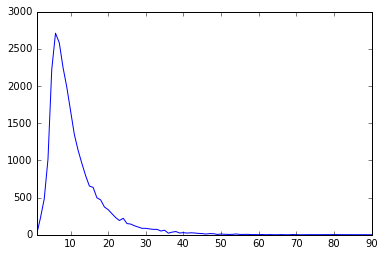

In [144]:
dd.OutDeg.value_counts().sort_index().plot()

In [155]:
c=test2.Nodes()
d=c.next()
d.GetId()

1280383

In [145]:
import snap

Graph = snap.GenRndGnm(snap.PNGraph, 100, 1000)
for NI in Graph.Nodes():
    FarCentr = snap.GetFarnessCentr(Graph, NI.GetId())
    print "node: %d centrality: %f" % (NI.GetId(), FarCentr)

count    24728.000000
mean        11.156260
std          7.592602
min          1.000000
25%          6.000000
50%          9.000000
75%         13.000000
max         90.000000
Name: OutDeg, dtype: float64

In [184]:
c=test2.Nodes()

print c.next.GetId()
%time GetFarnessCentr(test2, d.GetId())

AttributeError: 'method-wrapper' object has no attribute 'GetId'

In [190]:
%%time

import snap


Nodes = TIntFltH()
Edges = TIntPrFltH()
snap.GetBetweennessCentr(test2, Nodes, Edges, 1.0)
# for node in Nodes:
#     print "node: %d centrality: %f" % (node, Nodes[node])
# for edge in Edges:
#     print "edge: (%d, %d) centrality: %f" % (edge.GetVal1(), edge.GetVal2(), Edges[edge])

CPU times: user 17min 22s, sys: 0 ns, total: 17min 22s
Wall time: 17min 21s


In [195]:
cc=np.array([Nodes[node] for node in Nodes])
   

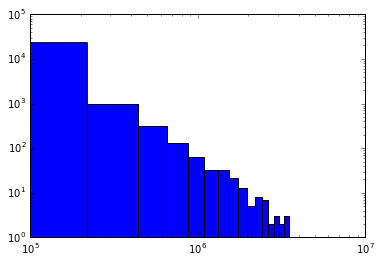

In [202]:
import matplotlib.pyplot as plt
plt.hist(cc,bins=30)
plt.xscale('log')
plt.yscale('log')

##   社区发现

## 短信

In [73]:
# mpc_comm_df,mpc_cmm_mo=getCNMCommDetect(ConvertGraph(PUNGraph,MPCs))  ##电话网络
# cdr_comm_df,cdr_cmm_mo=getCNMCommDetect(ConvertGraph(PUNGraph,CDRs))
sms_comm_df,sms_cmm_mo=getCNMCommDetect(ConvertGraph(PUNGraph,SMSs))


In [95]:

# clusters = IGraph.community_walktrap(g, weights="weight").as_clustering()
SavePajek()

11957

In [15]:
getNum_comm=lambda  df:df.T.describe()[:1].T.sort_values('count',ascending=False)

In [19]:
getNum_comm(mpc_comm_df).shape

(55, 1)

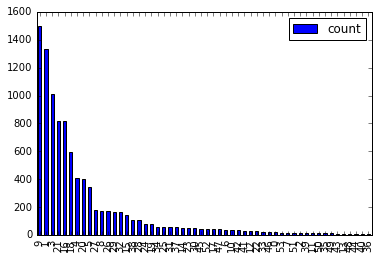

In [170]:
getNum_comm(cdr_comm_df).plot.bar()

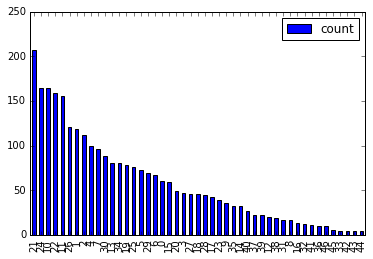

In [74]:
getNum_comm(sms_comm_df).plot.bar()

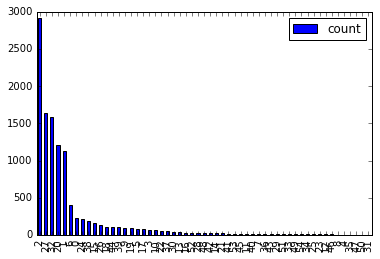

In [22]:
getNum_comm(mpc_comm_df).plot.bar()

In [29]:
# H.AddDat(1, "blue")
# H.AddDat(2, "blue")
# H.AddDat(3, "red")
# H.AddDat(4, "red")

In [90]:
d=getInOutDegrees(app_conatcts)

In [92]:
d.shape

(77219, 2)

In [28]:
sms_comm_df.values[0]

array([ 5508439.,  5942781.,  7527308.,  7261224.,  6202377.,  6050623.,
        5150847.,  5985319.,  8188162.,  5944732.,  8129089.,  7658731.,
        5531392.,  6686112.,  8121710.,  8790390.,  9221733.,  6474838.,
        8104937.,  4994144.,  7957439.,  7564056.,  8396261.,  5855966.,
        5512254.,  5601837.,  5865466.,  5923512.,  4997159.,  5184863.])

In [96]:
def adddH(df):
    H = TIntStrH()
    for i in df.index.values:
        for line in df.values[i]:
            H[line]=str(i)
    return  H

In [102]:
h=adddH(sms_comm_df)
SavePajek(call_records, "Card.net")

In [79]:
CDRs.GetNodes()

11957

In [ ]:
import snap

NIdColorH = snap.TIntStrH()
for i in range(100):
    if i % 2 == 0:
        NIdColorH[i] = "red"
    else:
        NIdColorH[i] = "blue"

Graph = snap.GenRndGnm(snap.PNGraph, 100, 1000)
snap.SavePajek(Graph, "Pajek_Graph1.out", NIdColorH)


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1516651,1532721,1552926,1639416,1650233,1652127.0,1696410.0,1721418.0,1732268.0,1744649.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1519676,1718813,1870662,2174859,2200223,2237624.0,2357018.0,2466360.0,2530594.0,2542391.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1547686,1814926,1819134,2074586,2078336,2137163.0,2215218.0,2807641.0,2967159.0,3023736.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1584847,1585563,1970439,1988346,2012368,2015694.0,2099227.0,2123900.0,2261721.0,2352351.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1593803,1654888,1659763,1880691,2104070,2174184.0,2248474.0,2530676.0,2539918.0,2540265.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1595191,1654253,1734712,1807184,1963726,2146873.0,2147894.0,2152902.0,2222862.0,2393098.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1599303,1744202,1856214,2264778,2315864,2412878.0,2574339.0,2662363.0,2770126.0,2892118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1615866,1618063,1709316,1745345,1828884,1883237.0,1885265.0,1917896.0,1926294.0,1951062.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1626552,1753602,3974559,4229627,5025197,5140263.0,5207880.0,5230981.0,5248724.0,5374888.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1732210,3380623,3575884,3698497,3755012,3855595.0,3891789.0,3911796.0,3918442.0,3925001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
